# STATISTICAL MACHINE LEARNING

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
class Dataset(object):
    def __init__(self):
        raise notImplementedError()
    
    def __len__(self):
        raise notImplementedError()
    
    def __get_item__(self):
        raise notImplementedError()
    

In [10]:
class WrapperDataset(Dataset):
    def __init__(self,data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __get_item__(self,index):
        return self.data[index]

In [4]:
class Gaussian_Cond_Distr_Dataset(Dataset):
    def __init__(self,p_y,t_dim,mu_t, sigma_t, length_dataset,seed):
        ''' build a dataset with x distributed with gaussian conditional probability.
        Y is a dichotomous RV.
        T|Y is a RV distributed following a multinormal distribution.
        
        p_y: probability that Y = 1.
        t_dim: dimension of the RV T.
        mu_t: list with 2 elements: [mean(T|Y=0),mean(T|Y=1)]
        sigma_t: list of covariance Matrix: [cov(T|Y=0),cov(T|Y=1)]
        
        '''
        np.random.seed(seed)
        self.data = []
        for i in range(length_dataset):
            temp = np.random.random()
            if temp<p_y:
                y = 1
                if t_dim==1:
                    t = np.random.normal(loc = mu_t[1], scale = sigma_t[1])
                else:
                    t = np.random.multivariate_normal(mean= mu_t[1], cov = sigma_t[1])
                    
            else:
                y = 0
                if t_dim==1:
                    t = np.random.normal(loc = mu_t[0], scale = sigma_t[0])
                else:
                    t = np.random.multivariate_normal(mean= mu_t[0], cov = sigma_t[0])
                    
            self.data.append((t,y))
    def __len__(self):
        return len(self.data)
    
    def __get_item__(self, index):
        return self.data[index]
    
            
            

In [5]:
def plot2DDataset(dataset):
    '''plot a dataset: the red points are labelled with y=1, the blue ones with y=0'''
    for i in range(dataset.__len__()):
        x = dataset.__get_item__(i)
        if x[1]==1:
            plt.plot(*x[0],'r*')
        else:
            plt.plot(*x[0],'b.')
    plt.show()

In [12]:
? plt.plot

In [37]:
t_dim = 2
p_y = 0.5
mu_t = [[0,0],[5,5]]
sigma_t = [np.diag([1,1]), np.diag([1,1])]
length_dataset = 200
seed = 3
dataset = Gaussian_Cond_Distr_Dataset(p_y,t_dim,mu_t, sigma_t, length_dataset,seed)

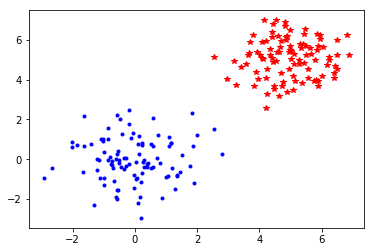

In [38]:
plot2DDataset(dataset)

In [20]:
class Bootstrap(object):
    def __init__(self, dataset, nb_bootstrap, seed=None):
        ''' create n bootstrap sample from a dataset.
        
        dataset: Dataset object
        
        nb_bootstrap: int number 
        
        seed: seed used for random number generation, if not given the seed
        will not be modified.
        '''
        self.dataset = dataset
        self.models = None
        BOOError = np.nan
        if seed != None:
            np.random.seed(seed)
        
        # create bootstrap samples
        indexes = np.arange(self.dataset.__len__())
        self.list_of_bootstrap_dataset = []
        self.binary_matrix = np.ones((nb_bootstrap,self.dataset.__len__()))
        for i in range(nb_bootstrap):
            temp = np.random.choice(indexes, size = self.dataset.__len__(), replace = True)
            self.list_of_bootstrap_dataset.append(temp)
            self.binary_matrix[i,np.array(temp)] = 0
            
    def __len__(self):
        return len(self.list_of_bootstrap_dataset)
    
    def __get_element__(self, index_dataset, index):
        ''' get the (index)^th element from the (index_dataset)^th bootstrap dataset.'''
        
        return dataset.__get_item__(self.list_of_bootstrap_dataset[index_dataset][index])
    
    def __get_dataset__(self, index_dataset):
        data = [self.dataset.__get_item__(index) for index in self.list_of_bootstrap_dataset[index_dataset]]
        data = WrapperDataset(data)
        
        return data
    def train_models(self, model_name):
        nb_models = self.__len__()
        self.models = [model_name(self.__get_dataset__(i)).__train__() for i in range(nb_models)]
    
    def compute_BOOerror(self):
        nb_models = self.__len__()
        errors = []
        if self.models == None:
            print('Error the models were not defined')
            return 0
        for j in range(self.dataset.__len__()):
            if self.binary_matrix[:,j].sum()>0:
                temp = np.where(self.binary_matrix[:,j])[0]
                error = 0
                x,y = self.dataset.__get_item__(j)
                for model in self.models[temp]:
                    prediction = model.__predict__(x)
                    error+= 1*(prediction == y)
                errors.append(error/self.binary_matrix[:,j].sum())
        
        BOOError = np.mean(errors)
        
        return BOOError
    def compute_train_error(self, model_name):
        '''compute the train error on the entire dataset for a given model'''
        model = model_name(self.dataset)
        model.train()
        train_error = model.__compute_train_error__()
        return train_error
    
    def compute_632_error(self, model_name):
        error = 0.368*self.compute_train_error(model_name) + 0.632* self.compute_BOOerror()
        return error
        

In [15]:
class Model(object):
    def __init__(self):
        raise notImplementedError()
    def __train__(self):
        raise notImplementedError()
    def __predict__(self):
        raise notImplementedError()
    def __get_train_error__(self):
        raise notImplementedError()

In [16]:
class LDAModel(Model):
    def __init__(self,dataset):
        self.dataset = dataset
        self.model = LinearDiscriminantAnalysis()
        self.train_error = np.nan
    def __train__(self):
        data=[]
        label=[]
        for i in range(dataset.__len__()):
            x,y = dataset.__get_item__(i)
            data.append(x)
            label.append(y)
        data = np.array(data)
        label = np.array(label)
        self.model.fit(data,label)
        self.train_error = self.model.score(data,label)
    
    def __predict__(self,x):
        y=self.model.predict(x)
        return y
    
    def __get_train_error__(self):
        return self.train_error